In [23]:
import numpy as np
import pandas as pd
from arch import arch_model
from metrics import eval_preds, composite_score, quantiles


df = pd.read_csv("spy_data.csv", index_col=0, parse_dates=[0])
df = df[["log_ret", "rv5", "bv"]].copy()

# Scale returns to percent 
df["r"] = 100.0 * df["log_ret"]

In [24]:
n = len(df)
i_train = int(0.70 * n)
i_val   = int(0.85 * n)

r = df["r"] # target variable for prediction

r_train = r.iloc[:i_train]
r_val   = r.iloc[i_train:i_val]
r_test  = r.iloc[i_val:]


# GARCH model

### Functions to compute VaR

In [25]:
from scipy.stats import norm

#Return q_alpha for the model's standardized innovation distribution.
def dist_quantile(residual, alpha):
    
    distribution = residual.model.distribution
    name_of_the_distribution = distribution.name.lower()

    if "normal" in name_of_the_distribution:
        return norm.ppf(alpha)

    # For T Students
    params = []
    for p in distribution.parameter_names():
        params.append(residual.params[p])
    params = np.array(params, dtype=float)
    return distribution.ppf(alpha, params)

def one_step_var(residual, alpha):
    f = residual.forecast(horizon=1, reindex=False)
    mu = float(f.mean.iloc[-1, 0])
    var = float(f.variance.iloc[-1, 0])
    sigma = np.sqrt(var)

    q = dist_quantile(residual, alpha)
    return mu + sigma * q 


### Rolling window

In [26]:
def rolling_var_forecast(
    r_series: pd.Series,
    start_idx: int,         
    p: int = 1,
    q: int = 1,
    vol: str = "GARCH",
    mean: str = "Constant",
    dist: str = "t",
    window: int | None = None,   
    refit_every: int = 20,
    quantiles=(0.01, 0.05, 0.10),
):
    
   
    dates = r_series.index
    var_fc = {a: [] for a in quantiles}
    out_dates = []

    residuals = None

    for t in range(start_idx, len(r_series) - 1):
        if window is None:
            estimation_sample = r_series.iloc[: t + 1]
        else:
            estimation_sample = r_series.iloc[max(0, t + 1 - window) : t + 1]

        if (residuals is None) or ((t - start_idx) % refit_every == 0):
            am = arch_model(estimation_sample, mean=mean, vol=vol, p=p, q=q, dist=dist)
            residuals = am.fit(disp="off")

        out_dates.append(dates[t + 1])
        for a in quantiles:
            var_fc[a].append(one_step_var(residuals, a))

    out = pd.DataFrame({f"VaR_{int(100*a)}": var_fc[a] for a in quantiles}, index=out_dates)
    return out


## Parameters Tuning

In [27]:
import itertools

def tune_garch_on_val(r: pd.Series, i_train: int, i_val: int):
    grid = list(itertools.product(
        [1, 2], # p
        [1, 2], # q
        ["GARCH"],
        ["t", "normal"],
        [None, 500, 1000, 1500], # rolling window length
    ))

    rows = []
    for p, q, vol, dist, window in grid:
        var_fc = rolling_var_forecast(
            r, start_idx=i_train,
            p=p, q=q, vol=vol, mean="Constant", dist=dist,
            window=window, refit_every=1,
            quantiles=(0.01, 0.05, 0.10)
        )

        val_mask = (var_fc.index >= r.index[i_train]) & (var_fc.index < r.index[i_val])
        var_fc_val = var_fc[val_mask]
        r_val_real = r.loc[var_fc_val.index]

        preds = {alpha: var_fc_val[f"VaR_{int(100*alpha)}"].values for alpha in quantiles}
        metrics_by_q = eval_preds(r_val_real.values, preds, quantiles)
        score = composite_score(metrics_by_q, quantiles)

        avg_metrics = {}
        for a in quantiles:
            avg_metrics[a] = {
                "actual_coverage": float(metrics_by_q[a]["actual_coverage"]),
                "pinball_loss": float(metrics_by_q[a]["pinball_loss"]),
                "kupiec_pval": float(metrics_by_q[a]["kupiec_pval"]) if np.isfinite(metrics_by_q[a]["kupiec_pval"]) else np.nan,
            }

        rows.append({
            "p": p, "q": q, "vol": vol, "dist": dist, "window": window,
            "score": score,
            "cov_1%": avg_metrics[0.01]["actual_coverage"],
            "cov_5%": avg_metrics[0.05]["actual_coverage"],
            "cov_10%": avg_metrics[0.10]["actual_coverage"],
            "pin_1%": avg_metrics[0.01]["pinball_loss"],
            "pin_5%": avg_metrics[0.05]["pinball_loss"],
            "pin_10%": avg_metrics[0.10]["pinball_loss"],
            "pval_1%": avg_metrics[0.01]["kupiec_pval"],
            "pval_5%": avg_metrics[0.05]["kupiec_pval"],
            "pval_10%": avg_metrics[0.10]["kupiec_pval"],
        })
        print(f"Done p={p}, q={q}, vol={vol}, dist={dist}, window={window} -> score={score:.4f}")

    res_grid = pd.DataFrame(rows).sort_values("score").reset_index(drop=True)
    return res_grid


In [28]:
res_grid = tune_garch_on_val(r, i_train, i_val)

# Show top 5 configurations
print("\nTop 5 configurations:")
for i, row in res_grid.head(5).iterrows():
    print(
        f"{i+1}. Score: {row['score']:.4f} | p={int(row['p'])}, q={int(row['q'])}, "
        f"vol={row['vol']}, dist={row['dist']}, window={row['window']}"
    )


Done p=1, q=1, vol=GARCH, dist=t, window=None -> score=0.0926
Done p=1, q=1, vol=GARCH, dist=t, window=500 -> score=0.0920
Done p=1, q=1, vol=GARCH, dist=t, window=500 -> score=0.0920
Done p=1, q=1, vol=GARCH, dist=t, window=1000 -> score=0.0916
Done p=1, q=1, vol=GARCH, dist=t, window=1000 -> score=0.0916
Done p=1, q=1, vol=GARCH, dist=t, window=1500 -> score=0.0916
Done p=1, q=1, vol=GARCH, dist=t, window=1500 -> score=0.0916
Done p=1, q=1, vol=GARCH, dist=normal, window=None -> score=0.0927
Done p=1, q=1, vol=GARCH, dist=normal, window=None -> score=0.0927
Done p=1, q=1, vol=GARCH, dist=normal, window=500 -> score=0.0918
Done p=1, q=1, vol=GARCH, dist=normal, window=500 -> score=0.0918
Done p=1, q=1, vol=GARCH, dist=normal, window=1000 -> score=0.0917
Done p=1, q=1, vol=GARCH, dist=normal, window=1000 -> score=0.0917
Done p=1, q=1, vol=GARCH, dist=normal, window=1500 -> score=0.0918
Done p=1, q=1, vol=GARCH, dist=normal, window=1500 -> score=0.0918
Done p=1, q=2, vol=GARCH, dist=t, 

### VaR forecasts on test set

In [30]:
# Extract best hyperparameters
best_row = res_grid.iloc[0]
best_score = best_row["score"]
best_p = int(best_row["p"])
best_q = int(best_row["q"])
best_vol = best_row["vol"]
best_dist = best_row["dist"]
best_window = int(best_row["window"]) if pd.notna(best_row["window"]) else None

print(f"Best configuration:")
print(f"  p={best_p}, q={best_q}")
print(f"  vol={best_vol}")
print(f"  dist={best_dist}")
print(f"  window={best_window}")
print(f"  Validation score: {best_score:.4f}")

# Generate forecasts on test set
var_oos = rolling_var_forecast(
    r, start_idx=i_train,
    p=best_p, q=best_q,  vol=best_vol, mean="Constant",dist=best_dist,
    window=best_window,
    refit_every=1, quantiles=quantiles
)



print(f"\nGenerated {len(var_oos)} VaR forecasts for test period")
var_oos.head()

Best configuration:
  p=1, q=2
  vol=GARCH
  dist=t
  window=1500
  Validation score: 0.0916

Generated 1391 VaR forecasts for test period

Generated 1391 VaR forecasts for test period


,VaR_1,VaR_5,VaR_10
2012-12-18,-1.907834,-1.116224,-0.795961
2012-12-19,-2.023866,-1.187117,-0.848110
2012-12-20,-2.064444,-1.210536,-0.864874
2012-12-21,-2.007220,-1.176186,-0.839686
2012-12-24,-2.090470,-1.228219,-0.878533


### Evaluate performance on test set

In [31]:
r_test_real = r.loc[var_oos.index]

preds = {alpha: var_oos[f"VaR_{int(100*alpha)}"].values for alpha in quantiles}
metrics_by_q = eval_preds(r_test_real.values, preds, quantiles)
comp = composite_score(metrics_by_q, quantiles)

results_summary = []
for a in quantiles:
    m = metrics_by_q[a]
    pval = m["kupiec_pval"]
    results_summary.append({
        "Alpha": f"{int(100*a)}%",
        "Expected_Coverage": f"{100*a:.1f}%",
        "Actual_Coverage": f"{100*m['actual_coverage']:.2f}%",
        "Quantile_Loss": f"{m['pinball_loss']:.4f}",
        "Kupiec_LR": f"{m['kupiec_LR']:.2f}",
        "Kupiec_p_value": f"{m['kupiec_pval']:.4f}",
        "Test_Result": "PASS" if (np.isfinite(pval) and pval > 0.05) else "FAIL",
    })

results_df = pd.DataFrame(results_summary)
print("\nTest Set Performance:")
print(results_df.to_string(index=False))
print(f"\nComposite score: {comp:.4f}")


Test Set Performance:
Alpha Expected_Coverage Actual_Coverage Quantile_Loss Kupiec_LR Kupiec_p_value Test_Result
   1%              1.0%           1.29%        0.0272      1.11         0.2917        PASS
   5%              5.0%           5.39%        0.0914      0.44         0.5077        PASS
  10%             10.0%          10.57%        0.1453      0.49         0.4838        PASS

Composite score: 0.0884


### Step 4: Visualize VaR forecasts vs actual returns

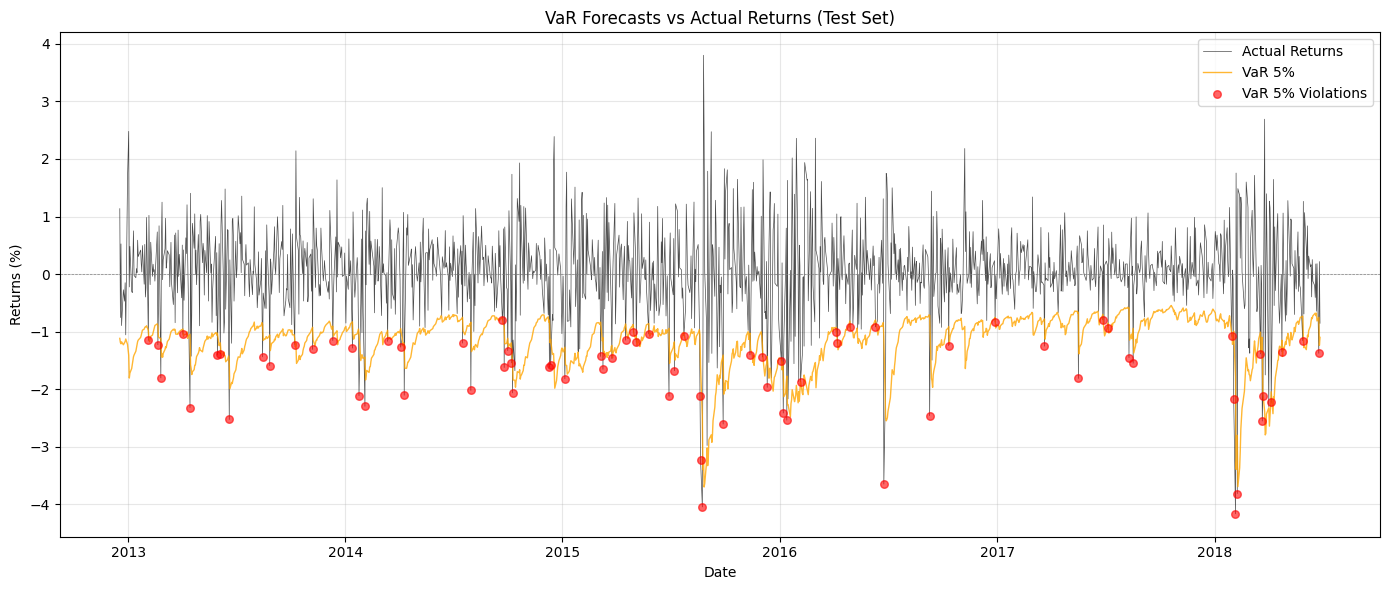


Total violations at 5% level: 75 out of 1391 days (5.39%)


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 6))

# Plot actual returns
ax.plot(r_test_real.index, r_test_real.values, 'k-', linewidth=0.5, label='Actual Returns', alpha=0.7)

# Plot VaR forecasts
#ax.plot(var_oos.index, var_oos['VaR_1'], 'r-', linewidth=1, label='VaR 1%', alpha=0.8 
ax.plot(var_oos.index, var_oos['VaR_5'], 'orange', linewidth=1, label='VaR 5%', alpha=0.8)
#ax.plot(var_oos.index, var_oos['VaR_10'], 'y-', linewidth=1, label='VaR 10%', alpha=0.8)

# Mark violations for 5% VaR
vio_5 = r_test_real < var_oos['VaR_5']
vio_dates = r_test_real[vio_5].index
vio_values = r_test_real[vio_5].values
ax.scatter(vio_dates, vio_values, color='red', s=30, zorder=5, label='VaR 5% Violations', alpha=0.6)

ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Returns (%)')
ax.set_title('VaR Forecasts vs Actual Returns (Test Set)')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTotal violations at 5% level: {vio_5.sum()} out of {len(vio_5)} days ({100*vio_5.mean():.2f}%)")